Pacotes

In [1]:
#%pip install stable-baselines3
#%pip install gym
#pip install gym-retro
#%pip install shimmy
#%pip install tensorflow
#%pip install 'shimmy>=0.2.1'
#%pip install keras-rl2

c:\Users\eduar\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Recompensa média por 100 episódios:

100 :  21.960000000000008
200 :  24.64
300 :  25.240000000000006
400 :  24.160000000000007
500 :  30.58
600 :  38.339999999999975
700 :  44.150000000000006
800 :  46.069999999999986
900 :  57.699999999999996
1000 :  73.19


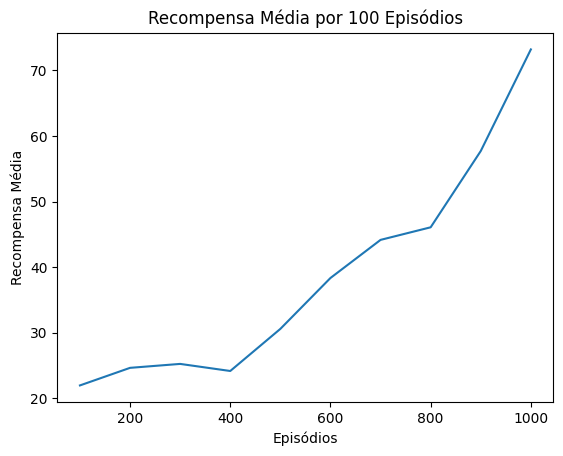

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

# Configurações do ambiente e parâmetros
env = gym.make('CartPole-v1')
action_space = env.action_space.n
state_space = env.observation_space.shape[0]

# Discretização do espaço de estados
state_bins = [
    np.linspace(-4.8, 4.8, 24),
    np.linspace(-4, 4, 24),
    np.linspace(-0.418, 0.418, 24),
    np.linspace(-4, 4, 24)
]

def discretize_state(state):
    state_index = []
    for i in range(len(state)):
        state_index.append(np.digitize(state[i], state_bins[i]) - 1)
    return tuple(state_index)

# Inicializar a Q-table com estados discretizados
q_table = np.zeros([24, 24, 24, 24, action_space])
learning_rate = 0.1
discount_rate = 0.99
exploration_rate = 1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.01
exploration_decay_rate = 0.001
num_episodes = 1000
max_steps_per_episode = 100

# Armazenamento de recompensas para plotagem
rewards_all_episodes = []

# Treinamento
for episode in range(num_episodes):
    state, _ = env.reset()
    state = discretize_state(state)
    done = False
    rewards_current_episode = 0

    for step in range(max_steps_per_episode):
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state])
        else:
            action = env.action_space.sample()

        new_state, reward, done, truncated, info = env.step(action)
        new_state = discretize_state(new_state)
        
        # Atualização da Q-table
        q_table[state][action] = q_table[state][action] * (1 - learning_rate) + \
                                 learning_rate * (reward + discount_rate * np.max(q_table[new_state]))

        state = new_state
        rewards_current_episode += reward

        if done or truncated:
            break

    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
    
    rewards_all_episodes.append(rewards_current_episode)

# Calcular recompensas médias por blocos de 100 episódios
rewards_per_hundred_episodes = np.split(np.array(rewards_all_episodes), num_episodes/100)
count = 100

print("Recompensa média por 100 episódios:\n")
for r in rewards_per_hundred_episodes:
    print(count, ": ", str(sum(r/100)))
    count += 100

# Plotar a recompensa média por 100 episódios
plt.plot(np.arange(1, len(rewards_per_hundred_episodes)+1) * 100, [sum(r/100) for r in rewards_per_hundred_episodes])
plt.xlabel('Episódios')
plt.ylabel('Recompensa Média')
plt.title('Recompensa Média por 100 Episódios')
plt.show()

env.close()